In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
import time
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
# from tqdm import tqdm, trange
from tqdm.notebook import  tqdm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
def get_data(t):
    t= np.array(t)
    y = (1 + 2*t)*np.power(np.e, t)
    z = 2*t*np.power(np.e, t)

    return np.array([y,z])

def r2_loss(pred, y):
    r2_loss = 1 - np.square(pred - y).sum() / np.square(y - np.mean(y)).sum()
    return r2_loss

def dcdt_func(t, c, ks):
    y,z = c
    dy = ks[0] * y -  ks[1]*z
    dz = ks[2] * y -  ks[3]*z

    dcdts = [dy,dz]

    return dcdts


In [5]:
def ltq_fit_rk(dataset, t_eval, c0,  maxfev=2400):

    def _error_loss( ks, *args):
        dataset, c0, t_eval, r2_trace = args

        sol_res = solve_ivp(dcdt_func, (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='Radau', args=(ks, ))
        cs = sol_res.y
        t_eval = sol_res.t

        loss = np.abs(cs - dataset).reshape(-1)
        # print(loss.sum(), end=',')
        # print(ks)
        return loss

    r2_trace = []

    ks_o = np.repeat(100, 4).tolist()
    ks_res = leastsq(_error_loss, ks_o, maxfev=maxfev, args=(dataset, c0, t_eval, r2_trace))[0]

    return ks_res, r2_trace


0.9998299818606069 0.9997415015022104 [ 84.84988839  92.85925695 105.08166151 115.4624735 ] [3, 2, 2, 1]


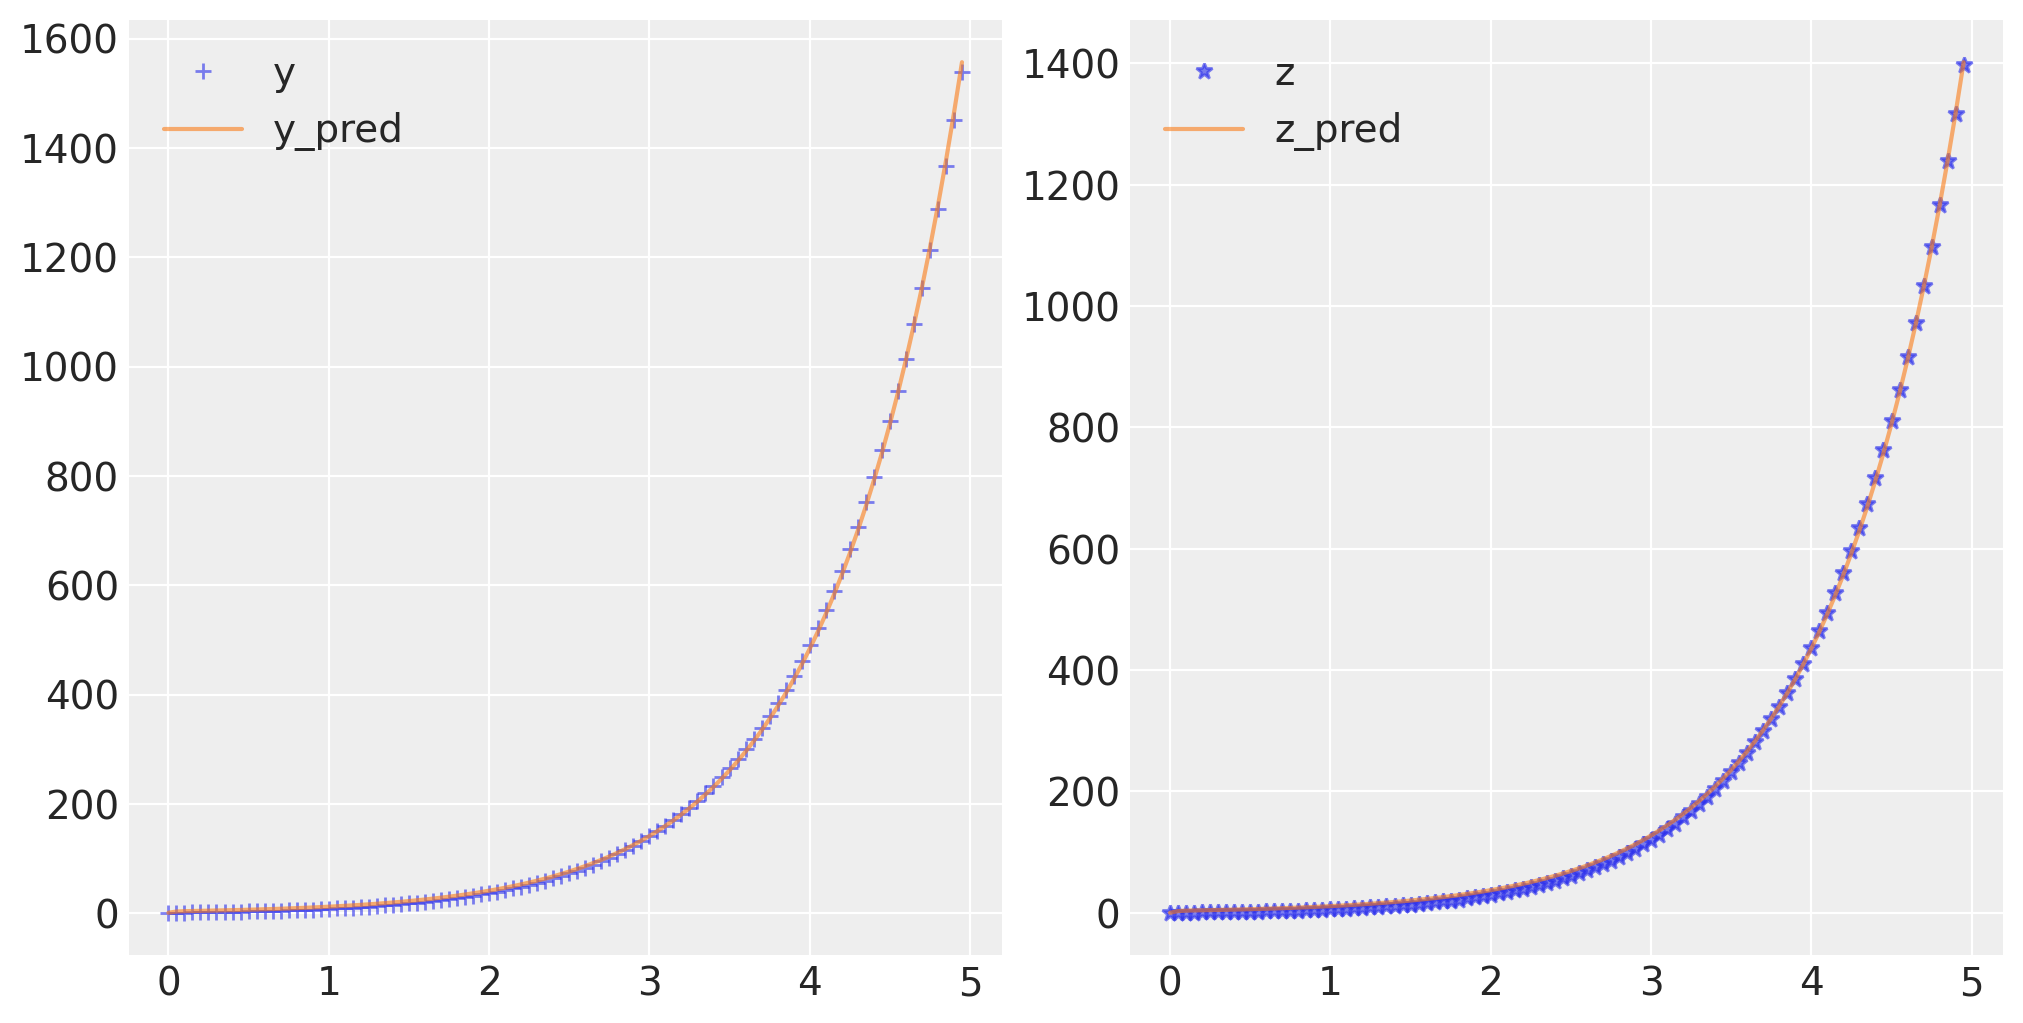

In [8]:
t_eval= np.arange(0, 5, 0.05)
dataset = get_data(t_eval)
c0 = [1,0]

ks_res, r2_trace = ltq_fit_rk(dataset, t_eval, c0)

sol_res = solve_ivp(dcdt_func, (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='Radau', args=(ks_res, ))
cs = sol_res.y
t_eval = sol_res.t
y,z = dataset


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
axes[0].plot(t_eval, y,'+', alpha=0.6, label='y')
axes[0].plot(t_eval, cs[0], alpha=0.6, label='y_pred')
axes[1].plot(t_eval, z,'*', alpha=0.6, label='z')
axes[1].plot(t_eval, cs[1], alpha=0.6, label='z_pred')
axes[0].legend()
axes[1].legend()

ks_gt = [3,2,2,1]
print(r2_loss(dataset[0], cs[0]),r2_loss(dataset[1], cs[1]), ks_res, ks_gt)
